### Import Basic libraries

In [9]:
!pip install numpy --upgrade

     |████████████████████████████████| 15.7 MB 269 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import numpy as np
np.__version__

'1.21.5'

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

## Install Tensorflow Object Detection API

##### clone github repository

In [ ]:
!git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 68889, done.
remote: Total 68889 (delta 0), reused 0 (delta 0), pack-reused 68889
Receiving objects: 100% (68889/68889), 577.14 MiB | 31.41 MiB/s, done.
Resolving deltas: 100% (48558/48558), done.


In [ ]:
!pip --version

pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


In [ ]:
%%bash
cd models/research
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
# Just a check to see if Object detection API is installed or not
! pip list | grep object-detection

object-detection              0.1


### Now we have successfully installed Tensorflow object detection API

### 2. Now Download the dataset. This dataset will be put into a new directory that is specific to this project

In [ ]:
%%bash 
cd /content
mkdir car_person_detection

In [ ]:
%cd /content/car_person_detection

/content/car_person_detection


In [ ]:
# check if there are any files created in the new directory
!ls -l

total 0


### Downloading the dataset from below link

https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz

In [ ]:
!wget https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz --quiet

#### Extracting files from the tar file

In [ ]:
!tar -xf trainval.tar.gz

In [ ]:
!ls -l trainval

total 96
drwxr-xr-x 2 501 staff  4096 Oct 19  2020 annotations
drwxr-xr-x 2 501 staff 90112 Feb  5 13:53 images


#### We have images and their annotations in the dataset
**Check if folders have files in them**

This json file will have annotations to all the images. Lets have a look

In [ ]:
N = 20
with open("trainval/annotations/bbox-annotations.json") as f:
  for i in range(0, N):
        print(f.readline(), end = '')

{
  "images": [
    {
      "file_name": "image_000000001.jpg",
      "width": 1024,
      "height": 768,
      "id": 0,
      "license": 1
    },
    {
      "file_name": "image_000000002.jpg",
      "width": 1024,
      "height": 576,
      "id": 1,
      "license": 1
    },
    {
      "file_name": "image_000000003.jpg",
      "width": 1024,
      "height": 683,


##### Total number of images in images folder

In [ ]:
!ls trainval/images/ | wc -l

2239


### I have cross verified the no. of annotations by using json path notation --> $.images[*].id gives 2239 results.

### 3. Data Pre-processing
Convert XML to CSV

The script will generate two files **(annotations_data.csv & image_data.csv)** because the bounding box details are in one json array and image name, height, width are in another json array.
We can merge the two files on a dataframe level for easy and faster operation.<br> 
Script file is in Detection folder with name **json_to_csv_converter.py** <br>

copy json_to_csv_converter.py from drive to current directory.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/json_to_csv_converter.py' .

Generate csv files using the script. The script requires two parameters.
1. -i indicating path of annotation json file (along with file name and extension)
2. -o indicating output folder path to create csv files

In [ ]:
!python json_to_csv_converter.py -i '/content/car_person_detection/trainval/annotations/bbox-annotations.json' -o '/content/car_person_detection'

JSON to CSV conversion successful


In [ ]:
!ls -l

total 717528
-rw-r--r-- 1 root root     385749 Feb  5 13:54 annotation_data.csv
-rw-r--r-- 1 root root      77341 Feb  5 13:54 image_data.csv
-rw------- 1 root root       2537 Feb  5 13:54 json_to_csv_converter.py
drwxr-xr-x 4  501 staff      4096 Oct 19  2020 trainval
-rw-r--r-- 1 root root  734266940 Oct 19  2020 trainval.tar.gz


Let's load data from both the files and create one single dataframe which has image details along with bounding box details and its class

In [4]:
ann_data_df = pd.read_csv('/content/car_person_detection/annotation_data.csv')
img_data_df = pd.read_csv('/content/car_person_detection/image_data.csv')

In [5]:
print("Shape of annotated dataframe: ",ann_data_df.shape)
print("Shape of Image data dataframe", img_data_df.shape)

Shape of annotated dataframe:  (16772, 6)
Shape of Image data dataframe (2239, 4)


In [6]:
data_df = pd.merge(ann_data_df, img_data_df)
data_df.head()

,img_id,img_label,xmin,ymin,xmax,ymax,filename,width,height
0,0,1,846,145,992,622,image_000000001.jpg,1024,768
1,0,1,848,216,1023,767,image_000000001.jpg,1024,768
2,0,2,74,159,149,240,image_000000001.jpg,1024,768
3,0,2,153,124,811,767,image_000000001.jpg,1024,768
4,1,1,488,281,516,352,image_000000002.jpg,1024,576


In [7]:
data_df.shape

(16772, 9)

Create class column for better understanding

In [79]:
train_df = pd.read_csv('train.csv')
train_df['img_class'].value_counts()

person    8460
car       4723
Name: img_class, dtype: int64

In [8]:
def get_class(img_label):
    if img_label == 1:
        return 'person'
    else:
        return 'car'

In [9]:
data_df['img_class'] = data_df['img_label'].apply(lambda v: get_class(v))
data_df.head(3)

,img_id,img_label,xmin,ymin,xmax,ymax,filename,width,height,img_class
0,0,1,846,145,992,622,image_000000001.jpg,1024,768,person
1,0,1,848,216,1023,767,image_000000001.jpg,1024,768,person
2,0,2,74,159,149,240,image_000000001.jpg,1024,768,car


In [10]:
# create a dictionary of label and class.
label_class_dict = dict(zip(data_df['img_label'], data_df['img_class']))
print(label_class_dict)

{1: 'person', 2: 'car'}


#### Let's have a look at images in our dataset

In [11]:
!pip uninstall opencv-python-headless==4.5.5.62

In [12]:
!pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.3 MB/s 


In [13]:
import cv2

In [ ]:
for rows in data_df[:5].values:
  print(rows)
  img = cv2.imread('trainval/images/'+rows[6])
  xmin = rows[2]
  ymin = rows[3]
  xmax = rows[4]
  ymax = rows[5]

  cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255, 0), 3)
  cv2.putText(img,rows[-1],(xmin, ymin-5),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10,7))
  plt.imshow(img)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Split the data into Train & Test

In [14]:
all_classes = data_df['filename'].unique()
all_classes.shape

(2239,)

In [15]:
#Split images between training and test
import numpy as np

#80% of the data will be used for training
mask = np.random.rand(all_classes.shape[0]) < 0.8

#Get Training and Test images
train_images = all_classes[mask]
test_images = all_classes[~mask] 

In [16]:
#Check number of images in training and test
train_images.shape, test_images.shape

((1805,), (434,))

In [17]:
#Split dataframe between training and test
train_df = data_df[data_df['filename'].isin(train_images)]
test_df = data_df[data_df['filename'].isin(test_images)]

In [18]:
train_df.shape, test_df.shape

((13615, 10), (3157, 10))

Save training and test data as csv

In [ ]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

### 4. Generate tfrecord from CSV
Tensorflow object detection API requires data in tfrecord format. This can be done using generate_tfrecord.py file.

In [ ]:
!cp '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/generate_tfrecord.py' .

The script file requires 3 inputs

1. --csv_input=<csv_file_path> : where is csv file located which was prepared in previous step
2. --img_path=<images_folder> : where are the actual images stored
3. --output_path=<output_file_path> : where the script can save the generated tfrecord file and what should be file name.

We will run script for training and test csv separately to create two tfrecord files.

In [ ]:
#generate tfrecord for training data
!python generate_tfrecord.py --csv_input=train.csv  --img_path='/content/car_person_detection/trainval/images' --output_path=train.tfrecord

2022-02-05 13:56:36.074177: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Successfully created the TFRecords: /content/car_person_detection/train.tfrecord


In [ ]:
#generate tfrecord for testing data
!python generate_tfrecord.py --csv_input=test.csv  --img_path='/content/car_person_detection/trainval/images' --output_path=test.tfrecord

2022-02-05 13:56:50.212937: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Successfully created the TFRecords: /content/car_person_detection/test.tfrecord


### 5. Create Label Mapping File

In [19]:
#Dict which was created earlier will be used for building Label Mapping file
label_class_dict

{1: 'person', 2: 'car'}

In [20]:
#Build a pbtxt label file using label and class name
#This is required by Object detection API
#You can prepare it manually as well.

pbtxt_file_txt = ''
for label in sorted(label_class_dict.keys()):
    
    pbtxt_file_txt += "item {\n  id: " + str(label) + "\n  name: '" +  label_class_dict[label] + "'\n}\n\n"

with open('label_map.txt','w') as pbfile:
    pbfile.write(pbtxt_file_txt)

In [21]:
#Review the file content
!cat label_map.txt

item {
  id: 1
  name: 'person'
}

item {
  id: 2
  name: 'car'
}



### 6. Download a pre-trained model

A list of pre-trained models is available at [TensorFlow model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). We will use 'ssd_mobilenet_v1_coco' model for transfer learning.


In [ ]:
#Download the model from zoo
!wget -q http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

In [ ]:
!tar -xf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

In [ ]:
!cp '/content/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_320x320_coco17_tpu-8.config' .

In [ ]:
!cp '/content/car_person_detection/ssd_mobilenet_v2_320x320_coco17_tpu-8.config' '/content/drive/MyDrive/Colab_Notebooks/Object_Detection'

### Modifying my config file
updating num_classes, num_steps, lebel_map.txt and tfrecord paths

In [ ]:
!cp '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/ssd_mobilenet_v2_320x320_coco17_modified.config' .

In [ ]:
config_file = 'ssd_mobilenet_v2_320x320_coco17_modified.config'

### 8. Training the model

In [ ]:
#Copy training file from 'models/research/object_detection' folder to current folder
!cp /content/models/research/object_detection/model_main_tf2.py .

cross verify all the files if exist or not

In [ ]:
!ls -l

total 1482088
-rw-r--r-- 1 root   root     385749 Feb  5 13:54 annotation_data.csv
drwxr-xr-x 4 root   root       4096 Feb  5 17:23 detection_model
-rw-r--r-- 1 root   root       7605 Feb  5 17:21 exporter_main_v2.py
-rw------- 1 root   root       4473 Feb  5 13:56 generate_tfrecord.py
-rw-r--r-- 1 root   root      77341 Feb  5 13:54 image_data.csv
-rw------- 1 root   root       2537 Feb  5 13:54 json_to_csv_converter.py
-rw-r--r-- 1 root   root         67 Feb  5 17:32 label_map.txt
-rw-r--r-- 1 root   root       4937 Feb  5 14:11 model_main_tf2.py
drwxr-xr-x 3 root   root       4096 Feb  5 18:30 pred_images
-rw------- 1 root   root       4366 Feb  5 14:10 ssd_mobilenet_v2_320x320_coco17_modified.config
drwxr-x--- 4 345018 89939      4096 Jul 11  2020 ssd_mobilenet_v2_320x320_coco17_tpu-8
-rw-r--r-- 1 root   root       4484 Feb  5 14:03 ssd_mobilenet_v2_320x320_coco17_tpu-8.config
-rw-r--r-- 1 root   root   46042990 Jul 11  2020 ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
-rw-r--r-- 1

#### Starting Training

In [ ]:
#Create a training folder to store model checkpoints/snapshots as training progresses
!mkdir training

In [ ]:
#start training
!python model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_every_n=100 --alsologtostderr

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
2022-02-05 14:11:50.299587: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W0205 14:11:50.367526 140528567605120 cross_device_ops.py:1386] There are non-GPU devices in `tf.distribute.Strategy`, not

### 9. Export trained model

From the saved model checkpoints, we will create a frozen trained model. Frozen here means to remove model nodes which are no longer needed in prediction. This reduces model size.

In [ ]:
#Copy export_inference_graph.py file from models/research/object_detection to current directory
!cp /content/models/research/object_detection/exporter_main_v2.py .

The export_inference_graph.py script file requires the following input:

1. --input_type <input_node_name> : This will be used during prediction to set model input
2. --pipeline_config_path <model_training_config_file_path> : where is model training config file located.
3. --trained_checkpoint_prefix <file_path__model_checkpoint> : Which checkpoint should be used to create final model.
4. --output_directory <frozen_model_directory> : where should the frozen model created by script should be stored.

In [ ]:
#Provide input name, config file location, training folder
!python exporter_main_v2.py --input_type "image_tensor" --pipeline_config_path {config_file} --trained_checkpoint_dir training/ --output_directory detection_model

2022-02-05 17:22:06.736540: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0205 17:22:07.130214 139903686035328 deprecation.py:615] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
INFO:tensorflow:depth of additional conv before box predictor: 0
I0205 17:22:15.893403 13

## Model Prediction

In [24]:
saved_model_path = 'detection_model/saved_model'
model = tf.saved_model.load(saved_model_path)

In [25]:
#Function to get predictions from a Detection model
def detector_prediction(image_file, confidence_threshold=0.5):

    """
    image_file: File path of the image for which prediction needs to be done
    confidence_threshold: Minimum confidence/probability for prediction to be considered
    """
    #Load image
    img = tf.keras.preprocessing.image.load_img(image_file)
    
    #Convert to numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')
    #Make it a batch of one example
    img_array = tf.expand_dims(img_array, axis=0)

    #Prediction
    output = model(img_array) #get list of tensors discussed above as output
    #print(output)
    detection_scores = output['detection_scores'].numpy()[0] #get detection scores
    detection_classes = output['detection_classes'].numpy()[0]
    detection_boxes = output['detection_boxes'].numpy()[0]

    #Select predictions for which probability is higher than confidence_threshold
    selected_predictions = detection_scores >= confidence_threshold

    selected_prediction_scores = detection_scores[selected_predictions]
    selected_prediction_classes = detection_classes[selected_predictions]
    selected_prediction_boxes = detection_boxes[selected_predictions]

    #De-normalize box co-ordinates (multiply x-coordinates by image width and y-coords by image height)
    img_w, img_h = img.size

    for i in range(selected_prediction_boxes.shape[0]):
        
        selected_prediction_boxes[i,0] *= img_h #ymin * img_w
        selected_prediction_boxes[i,1] *= img_w #xmin * img_h
        selected_prediction_boxes[i,2] *= img_h #ymax * img_w
        selected_prediction_boxes[i,3] *= img_w #xmax * img_h

    #Make all co-ordinates as integer
    selected_prediction_boxes= selected_prediction_boxes.astype(int)

    #Convert class indexes to actual class labels
    predicted_classes = []
    for i in range(selected_prediction_classes.shape[0]):
        predicted_classes.append(label_class_dict[int(selected_prediction_classes[i])])

    #Number of predictions
    selected_num_predictions = selected_prediction_boxes.shape[0]

    return {'Total Predictions': selected_num_predictions,
            'Scores': selected_prediction_scores, 
            'Classes': predicted_classes, 
            'Box coordinates': selected_prediction_boxes}

In [ ]:
pred_folder_path = '/content/car_person_detection/pred_images/'

In [26]:
def visualize_output(img_name, image_file, confidence_threshold=0.5):

    #Call model prediction function above
    output = detector_prediction(image_file, confidence_threshold=confidence_threshold)
    print(output)
    #Read image
    img = cv2.imread(image_file)

    #Draw rectangle for predicted boxes, also add predicted classes
    for i in range(output['Box coordinates'].shape[0]):

        box = output['Box coordinates'][i]
        
        #Draw rectangle - (ymin, xmin, ymax, xmax)
        img = cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (0,255,0), 2)
        
        #Add Label - Class name and confidence level
        label = output['Classes'][i] + ': ' + str(round(output['Scores'][i],2))
        img = cv2.putText(img, label, (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    #Conver BGR image to RGB to use with Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Display image
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.savefig(pred_folder_path+img_name)
    # plt.show()

In [ ]:
import cv2
from matplotlib import pyplot as plt

## Checking on some random images

{'Total Predictions': 2, 'Scores': array([0.79851544, 0.64109516], dtype=float32), 'Classes': ['car', 'car'], 'Box coordinates': array([[ 128,   12,  704,  926],
       [ 181,  871,  388, 1024]])}
{'Total Predictions': 4, 'Scores': array([0.8409735, 0.6997421, 0.6794946, 0.6421884], dtype=float32), 'Classes': ['car', 'person', 'person', 'car'], 'Box coordinates': array([[ 250,   63,  691,  984],
       [ 120,  939,  376, 1000],
       [ 122,  888,  361, 1000],
       [ 144,  823,  341,  960]])}
{'Total Predictions': 1, 'Scores': array([0.6786552], dtype=float32), 'Classes': ['car'], 'Box coordinates': array([[590, 513, 658, 616]])}
{'Total Predictions': 3, 'Scores': array([0.71789706, 0.712548  , 0.6209378 ], dtype=float32), 'Classes': ['person', 'car', 'car'], 'Box coordinates': array([[343, 290, 617, 407],
       [318,  47, 406, 122],
       [143,  43, 765, 973]])}
{'Total Predictions': 2, 'Scores': array([0.6373536 , 0.63294697], dtype=float32), 'Classes': ['person', 'car'], 'Box co

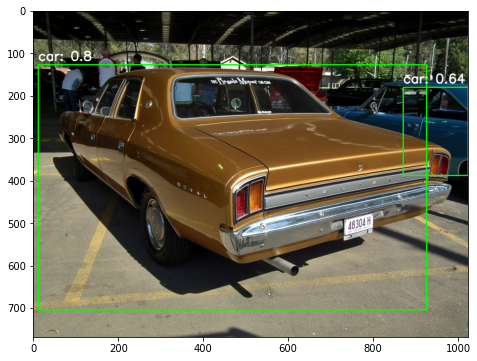

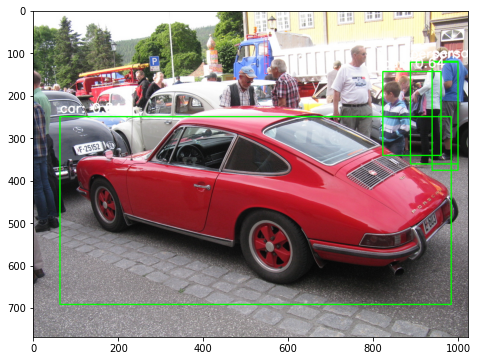

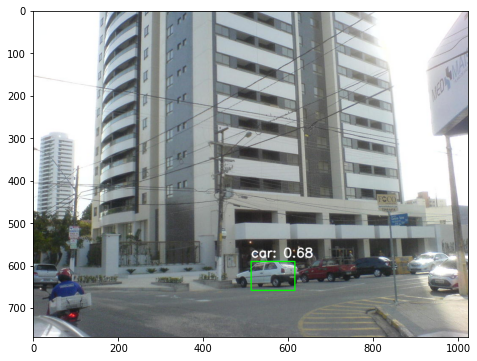

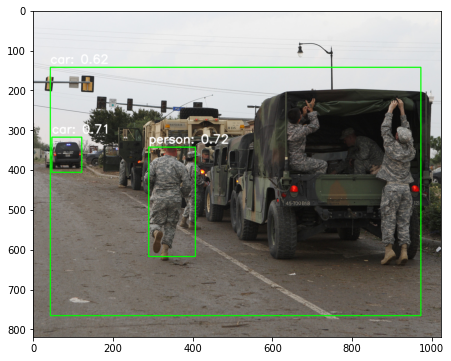

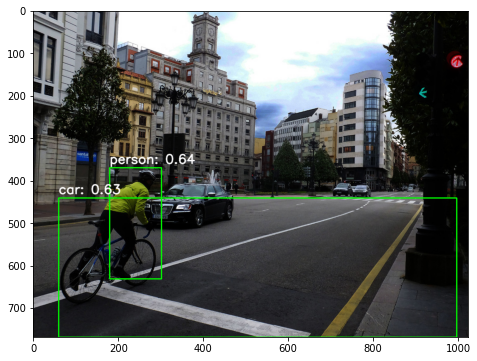

In [ ]:
random_img_list = [142, 144, 145, 150, 159]
for i in random_img_list:
  img_name = 'image_000000'+str(i)+'.jpg'
  test_img = 'trainval/images/'+img_name
  visualize_output(img_name, test_img, confidence_threshold=0.6)

In [ ]:
# Copying entire project to my local
!cp -r . '/content/drive/MyDrive/Colab_Notebooks/car_person_detection'

## Calculating Metrics

In [68]:
from copy import deepcopy
import seaborn as sns
%matplotlib inline

In [56]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [57]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [69]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

In [70]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [72]:
def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())
# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
    pred_boxes_pruned = deepcopy(pred_bb)
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
# Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
    for img_id in img_ids:
               
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
# Recalculate image results for this image
            print(img_id)
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr=0.5)
# calculate precision and recall
    prec, rec = calc_precision_recall(img_results)
    precisions.append(prec)
    recalls.append(rec)
    model_thrs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            print(recalls,"Recall")
            print(      recall_level,"Recall Level")
            print(       args, "Args")
            print(       prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [55]:
# Get Actual boxes of image
gt_boxes = dict()
img_file_name = 'image_000000142.jpg'
img_df = test_df[test_df['filename'] == img_file_name].iloc[:,2:6]
gt_boxes[img_file_name] = img_df.to_numpy().tolist()

# Get predicted image boxes and scores
pred_boxs = dict()
img_file_path = '/content/car_person_detection/trainval/images/'
result = detector_prediction(img_file_path+img_file_name, 0.5)
pred_boxs[img_file_name] = {'boxes': result.get('Box coordinates').tolist(),
                            'scores': result.get('Scores').tolist()}

In [76]:
get_avg_precision_at_iou(gt_boxes, pred_boxs)

Mode score :  0.5099090933799744
Mode score :  0.5941089987754822
Mode score :  0.6410951614379883
image_000000142.jpg


{'avg_prec': 0.0,
 'model_thrs': [0.6410951614379883],
 'precisions': array([0.]),
 'recalls': array([0.])}